# Using KNN to reclasify missing industry entries
Some entries have industries missing. The assumption is, if there are 10 or so tech industries and one is unclassifed, then it is likely a tech industry company

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# to ensure displayed tables don't truncate columns
pd.set_option('display.max_columns', None) 

In [3]:
leases = pd.read_csv('../Datasets/focused_lease.csv')

# Initial exploration
Checking out what leases latitude and longitude looks like

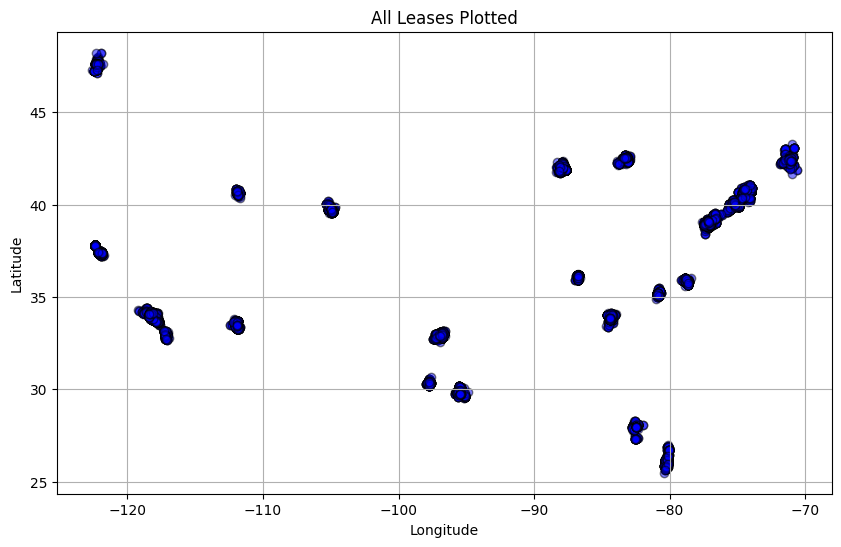

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(leases['lng'], leases['lat'], alpha=0.5, c='blue', edgecolors='k')

# Labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("All Leases Plotted")
plt.grid(True)

# Show plot
plt.show()

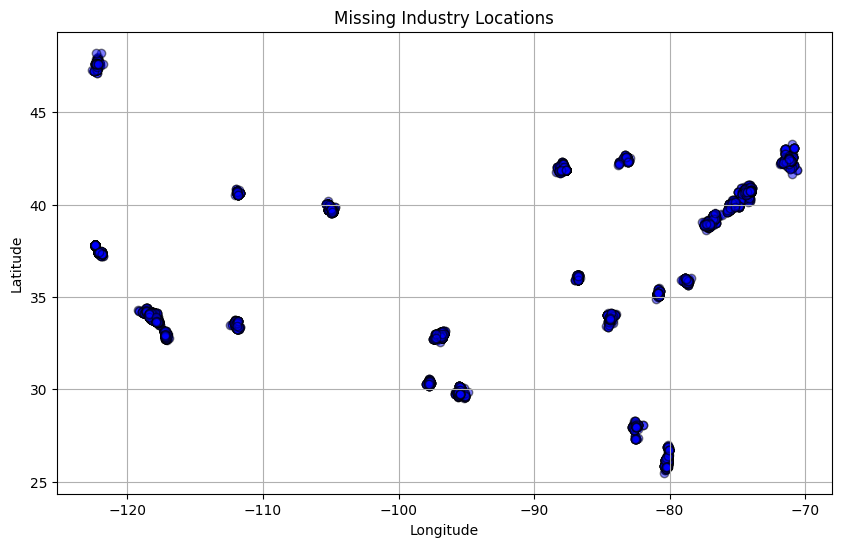

In [5]:
missing_industries = leases[leases['internal_industry'].isna()]

plt.figure(figsize=(10, 6))
plt.scatter(missing_industries['lng'], missing_industries['lat'], alpha=0.5, c='blue', edgecolors='k')

# Labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Missing Industry Locations")
plt.grid(True)

# Show plot
plt.show()


# Founding Unfounded Assumptions
We are going to now KNN to add extra entries that would've been unsuable. We will compare side by side what impacts the assumptions made.

In [6]:
def euclidean_distance(lat_x, long_x, lat_y, long_y, cutoff=50):
    """
    Computes the Euclidean distance (approximate) between two geographical points.
    If the distance exceeds the cutoff (default: 50 miles), return None.
    """
    # Convert degrees to radians
    lat_x, long_x, lat_y, long_y = map(np.radians, [lat_x, long_x, lat_y, long_y])
    
    # Approximate radius of Earth in miles
    R = 3958.8  

    # Compute differences
    delta_lat = lat_y - lat_x
    delta_long = long_y - long_x

    # Approximate Euclidean distance (ignoring Earth's curvature)
    distance = R * np.sqrt(delta_lat**2 + delta_long**2)

    # Apply cutoff
    if distance > cutoff:
        return None  # Cutoff exceeded
    return distance


In [ ]:
k = 11
min_k = 5

amputations = pd.DataFrame(columns=['chosen_industry', 'industries_looked_at'])
print("leases null industries before: ", leases['internal_industry'].isnull().sum())


for row in missing_industries.itertuples(index=False):
    state_leases = leases[(leases['state'] == row.state) & leases['internal_industry'].notna()]
    distances = []

    # Compute distances for all leases in the same state
    for lease in state_leases.itertuples(index=False):
        dist = euclidean_distance(row.lat, row.lng, lease.lat, lease.lng, cutoff=150)
        # print(dist)
        if dist is not None:  # Ignore distances beyond cutoff
            distances.append((dist, lease.internal_industry))

    if len(distances) < min_k:
        continue

    k_nearest = sorted(distances, key=lambda x: x[0])[:k]

    if k_nearest:
        industries = [industry for _, industry in k_nearest]
        most_common_industry = Counter(industries).most_common(1)[0][0]

        leases.loc[leases['index'] == row['index'], 'internal_industry'] = most_common_industry


        amputations = pd.concat([amputations, pd.DataFrame([{
            'chosen_industry': most_common_industry,
            'industries_looked_at': industries,
        }])], ignore_index=True)

    print(idx)

leases.to_csv('amputation_leases.csv', index=False, )
print(f'amp: {amputations.shape[0]} rows and {amputations.shape[1]} columns')
amputations





leases null industries before:  7061
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
2

,chosen_industry,industries_looked_at
0,"Technology, Advertising, Media, and Information","[Retail, Financial Services and Insurance, Fin..."
1,"Technology, Advertising, Media, and Information","[Technology, Advertising, Media, and Informati..."
2,"Technology, Advertising, Media, and Information","[Technology, Advertising, Media, and Informati..."
3,"Technology, Advertising, Media, and Information","[Government, Technology, Advertising, Media, a..."
4,"Technology, Advertising, Media, and Information","[Technology, Advertising, Media, and Informati..."
...,...,...
12570,"Technology, Advertising, Media, and Information","[Technology, Advertising, Media, and Informati..."
12571,"Technology, Advertising, Media, and Information","[Technology, Advertising, Media, and Informati..."
12572,"Technology, Advertising, Media, and Information","[Technology, Advertising, Media, and Informati..."
12573,"Technology, Advertising, Media, and Information","[Technology, Advertising, Media, and Informati..."
